<a href="https://colab.research.google.com/github/KevOdhiambo/Credit-Risk-Prediction/blob/main/Tupande_Data_Science_Test_R3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tupande Credit Risk Model**


One Acre Fund offers loans to hundreds of thousands of smallholder farmers. Farmers repay those loans over the course of the season in small installments. One Acre Fund wants to know at different points in the season which farmers might be at risk of defaulting so we can direct the field team to follow up with them to prevent that outcome from happening. For this exercise, you are expected to complete the three part deliverables highlighted below.bold text

**ReadMe**
# Credit Default Risk Prediction Model for One Acre Fund

## Project Overview
This project develops a machine learning model to predict loan repayment behavior for One Acre Fund, which provides loans to smallholder farmers. The goal is to achieve a 98% repayment rate while keeping default rates below 1%, enabling sustainable expansion of lending services.

## Business Objectives
1. Achieve a repayment rate of 98%
2. Reduce default rate to 1%
3. Expand farmer base by accurately targeting those likely to repay loans

## Dataset Description
The dataset contains loan information for farmers including:
- Client ID
- Loan Type
- Region
- Duka (store) name
- Cumulative amount paid
- Nominal contract value
- Deposit amount
- Contract start date
- Area
- Sales territory

## Top 5 Key Features by Correlation with Target
1. Nominal contract value (0.880)
2. Cumulative amount paid start (0.845)
3. Deposit amount (0.748)
4. Repayment ratio (0.371)
5. Loan Type (0.111)

## Usage
Run the notebooks in sequence:

Data Preparation
Exploratory Analysis
Model Development
Model Performance Metrics
Model accuracy
Holdout Prediction




In [ ]:
#install necessary modules
!pip install xgboost
!pip install lightgbm
!pip install openpyxl

In [17]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,  learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# 1. Load and Initial Data Exploration

train_df = pd.read_excel('/content/drive/MyDrive/DS Task/DSR3DATA.xlsx',sheet_name="Training")
holdout_df = pd.read_excel('/content/drive/MyDrive/DS Task/DSR3DATA.xlsx',sheet_name="Holdout")

print("Training set shape:", train_df.shape)
print("Holdout set shape:", holdout_df.shape)

Training set shape: (36215, 11)
Holdout set shape: (9207, 10)


In [25]:
#Preview the training data
train_df.head(5)

,client_id,Loan_Type,region,duka_name,cumulative_amount_paid,nominal_contract_value,deposit_amount,contract_start_date,area,sales_territory,cumulative_amount_paid_start
0,206a00541b2d03a61786f2f7880f5e0a98854ef67be07d...,Group Loan,Upper Western,Luuya,5383.287252,5383.287252,576.986844,2023-03-01,UW10,Sales Territory 189,4399.524684
1,b2fa984220bcdc664c185a776b4f42f12af27b689bd5be...,Group Loan,Lower Western,Majengo,1710.141496,1952.411541,610.764820,2023-02-25,LW12,Sales Territory 119,610.764820
2,91e017583615b0d0c1f66b3a9cfd6abc8dce0050cd7d2c...,Group Loan,Nyanza,Bomet,1273.739414,5256.271151,1081.842238,2023-02-11,NZ12,Sales territory 949,1084.096076
3,19289e32292c7268a092df4c8f529d8a3716f94012b077...,Individual Loan,Nyanza,Nyakongo,270.032839,806.240904,192.880599,2023-01-06,NZ10,Sales Territory 943,243.222435
4,35f9a64a0d421171d5ad07c3441ddd3e7db87492099be6...,Group Loan,Upper Western,Bokoli,11665.127083,11665.127083,1950.690148,2023-02-02,UW10,Sales Territory 747,10211.443524


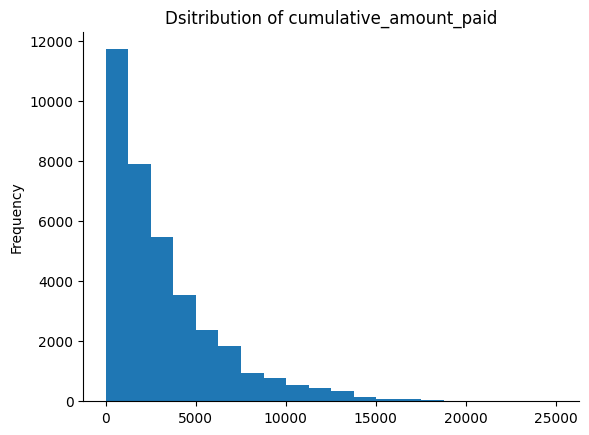

In [ ]:
# @title Distribution of cumulative_amount_paid

from matplotlib import pyplot as plt
train_df['cumulative_amount_paid'].plot(kind='hist', bins=20, title='Dsitribution of cumulative_amount_paid')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [26]:
# Basic data exploration
def explore_data(df, title="Dataset"):
    print(f"\n=== {title} ===")
    print("\nFirst few rows:")
    print(df.head())
    print("\nData Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())

explore_data(train_df, "Training Dataset")
explore_data(holdout_df, "Holdout Dataset")


=== Training Dataset ===

First few rows:
                                           client_id        Loan_Type  \
0  206a00541b2d03a61786f2f7880f5e0a98854ef67be07d...       Group Loan   
1  b2fa984220bcdc664c185a776b4f42f12af27b689bd5be...       Group Loan   
2  91e017583615b0d0c1f66b3a9cfd6abc8dce0050cd7d2c...       Group Loan   
3  19289e32292c7268a092df4c8f529d8a3716f94012b077...  Individual Loan   
4  35f9a64a0d421171d5ad07c3441ddd3e7db87492099be6...       Group Loan   

          region duka_name  cumulative_amount_paid  nominal_contract_value  \
0  Upper Western     Luuya             5383.287252             5383.287252   
1  Lower Western   Majengo             1710.141496             1952.411541   
2         Nyanza     Bomet             1273.739414             5256.271151   
3         Nyanza  Nyakongo              270.032839              806.240904   
4  Upper Western    Bokoli            11665.127083            11665.127083   

   deposit_amount contract_start_date  area      

In [27]:
# remove missing values as they are less than 2%
train_df = train_df.dropna()
holdout_df = holdout_df.dropna()

In [28]:
# summary Statistics of the Train Data
print(train_df.describe())

       cumulative_amount_paid  nominal_contract_value  deposit_amount  \
count            36157.000000            36157.000000    36157.000000   
mean              3179.029119             4021.801684      811.569953   
min                  0.000000                0.054589        0.000000   
25%                916.724873             1441.675095      260.970342   
50%               2225.872359             3092.424981      585.046911   
75%               4428.737711             5705.484943     1110.630672   
max              25045.784318            30779.367701    11165.004178   
std               3080.494188             3439.951691      777.051324   

                 contract_start_date  cumulative_amount_paid_start  
count                          36157                  36157.000000  
mean   2023-02-04 20:22:11.393644288                   1912.606764  
min              2023-01-03 00:00:00                  -6198.008185  
25%              2023-01-20 00:00:00                    544.476858

**Exploratory Data Analysis**


In [ ]:
# Distribution of Loan Types
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='Loan_Type')
plt.title('Distribution of Loan Types')
plt.show()

In [ ]:
# Distribution of Loan Types
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='Loan_Type')
plt.title('Distribution of Loan Types')
plt.show()

In [ ]:
# Visualize repayment patterns by region, sales territory
plt.figure(figsize=(12, 8))
sns.barplot(x='region', y='cumulative_amount_paid', data=train_df)
plt.title('Repayment by Region')
plt.xlabel('Region')
plt.ylabel('Cumulative Amount Paid')
plt.show()

In [29]:
# Function to calculate repayment rate
def calculate_repayment_rate(df):
    """Calculate repayment rate as percentage of loans fully paid"""
    return (train_df['cumulative_amount_paid'] >= train_df['nominal_contract_value']).mean() * 100

repayment_rate=calculate_repayment_rate(train_df)
print(f"Repayment Rate: {repayment_rate}%")


Repayment Rate: 48.39450175622977%


In [30]:
# Function to calculate default rate
def calculate_default_rate(df):
    """Calculate default rate as percentage of loans with less than 50% repayment"""
    return (df['cumulative_amount_paid'] < (0.5 * df['nominal_contract_value'])).mean() * 100

default_rate = calculate_default_rate(train_df)
print(f"Default Rate: {default_rate}%")

Default Rate: 19.87167076914567%


**Feature engineering**


In [31]:
# Feature Engineering
def engineer_features(df):
    """Create new features for the dataset"""
    df_copy = df.copy()

    # Convert contract_start_date to datetime
    df_copy['contract_start_date'] = pd.to_datetime(df_copy['contract_start_date'])

    # Calculate days since start
    df_copy['days_since_start'] = (pd.to_datetime('2023-11-01') -
                                  df_copy['contract_start_date']).dt.days

    # Calculate deposit ratio
    df_copy['deposit_ratio'] = df_copy['deposit_amount'] / df_copy['nominal_contract_value']

    # Drop original date column
    df_copy = df_copy.drop('contract_start_date', axis=1)

    return df_copy

# Apply feature engineering to both datasets
train_df_engineered = engineer_features(train_df)
holdout_df_engineered = engineer_features(holdout_df)

In [32]:
train_df_engineered.head()

,client_id,Loan_Type,region,duka_name,cumulative_amount_paid,nominal_contract_value,deposit_amount,area,sales_territory,cumulative_amount_paid_start,days_since_start,deposit_ratio
0,206a00541b2d03a61786f2f7880f5e0a98854ef67be07d...,Group Loan,Upper Western,Luuya,5383.287252,5383.287252,576.986844,UW10,Sales Territory 189,4399.524684,245,0.107181
1,b2fa984220bcdc664c185a776b4f42f12af27b689bd5be...,Group Loan,Lower Western,Majengo,1710.141496,1952.411541,610.764820,LW12,Sales Territory 119,610.764820,249,0.312826
2,91e017583615b0d0c1f66b3a9cfd6abc8dce0050cd7d2c...,Group Loan,Nyanza,Bomet,1273.739414,5256.271151,1081.842238,NZ12,Sales territory 949,1084.096076,263,0.205819
3,19289e32292c7268a092df4c8f529d8a3716f94012b077...,Individual Loan,Nyanza,Nyakongo,270.032839,806.240904,192.880599,NZ10,Sales Territory 943,243.222435,299,0.239234
4,35f9a64a0d421171d5ad07c3441ddd3e7db87492099be6...,Group Loan,Upper Western,Bokoli,11665.127083,11665.127083,1950.690148,UW10,Sales Territory 747,10211.443524,272,0.167224


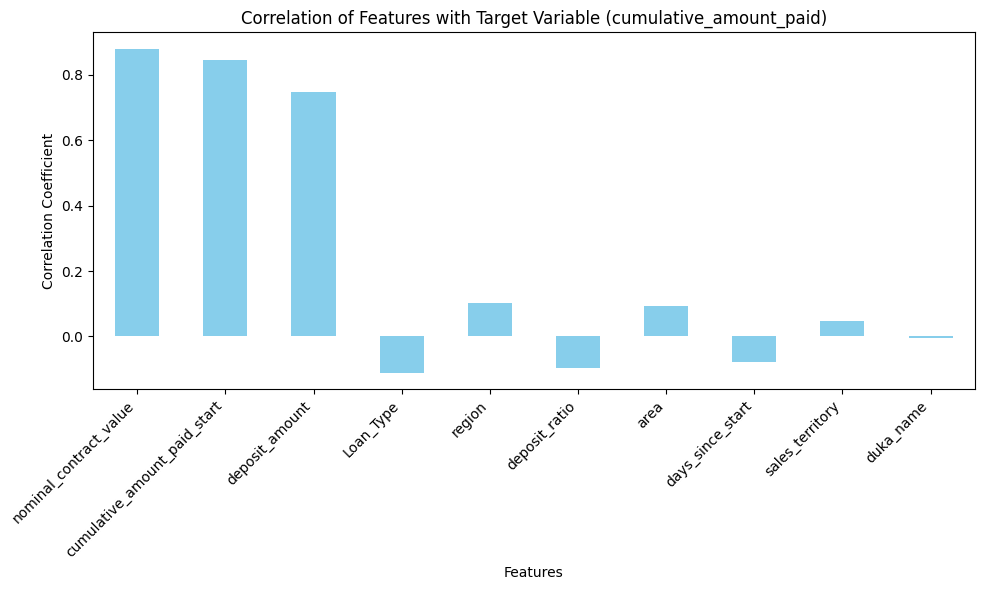

In [33]:
# Correlation Analysis for numerical features

df_encoded = train_df_engineered.copy()

# categorical features
categorical_features = ['area', 'Loan_Type', 'region', 'sales_territory', 'duka_name']

# Encoding categorical features
for feature in categorical_features:
    df_encoded[feature] = df_encoded[feature].astype('category').cat.codes

# features to calculate correlation with the target variable
features = [
    'nominal_contract_value',
    'cumulative_amount_paid_start',
    'deposit_amount',
    'Loan_Type',
    'region',
    'deposit_ratio',
    'area',
    'days_since_start',
    'sales_territory',
    'duka_name'
]

# Calculate correlation of each feature with cumulative_amount_paid
correlations = df_encoded[features + ['cumulative_amount_paid']].corr()['cumulative_amount_paid'].drop('cumulative_amount_paid')

# Plotting the correlations as a bar plot
plt.figure(figsize=(10, 6))
correlations.plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Target Variable (cumulative_amount_paid)')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [34]:
# Sort the already computed correlations by absolute values in descending order
top_correlations = correlations.abs().sort_values(ascending=False)

# Display the top correlated features
print("Top Correlated Features with Target:")
print(top_correlations)

Top Correlated Features with Target:
nominal_contract_value          0.880303
cumulative_amount_paid_start    0.844601
deposit_amount                  0.747595
Loan_Type                       0.110921
region                          0.103210
deposit_ratio                   0.097888
area                            0.091800
days_since_start                0.078638
sales_territory                 0.047422
duka_name                       0.003928
Name: cumulative_amount_paid, dtype: float64


In [35]:
# Separate features based on correlation with target
important_features = [
    'nominal_contract_value',
    'cumulative_amount_paid_start',
    'deposit_amount',
    'Loan_Type',
    'region',
    'deposit_ratio',
    'area',
    'days_since_start',
    'sales_territory',
    'duka_name'
]

# Store client_ids
train_ids = train_df_engineered['client_id']
holdout_ids = holdout_df_engineered['client_id']

# Drop client_id
train_df_engineered = train_df_engineered.drop('client_id', axis=1)
holdout_df_engineered = holdout_df_engineered.drop('client_id', axis=1)

**Modeling**


In [37]:
# Prepare for modeling
# Separate target variable
X = train_df_engineered[important_features]
y = train_df_engineered['cumulative_amount_paid']
X_holdout = holdout_df_engineered[important_features]

# Initialize encoders and scalers
categorical_features = ['Loan_Type', 'region', 'area', 'sales_territory', 'duka_name']
numerical_features = [f for f in important_features if f not in categorical_features]

# Label Encoding
# Dictionary to hold the encoders for each categorical feature
encoders = {}

for cat_feature in categorical_features:
    le = LabelEncoder()

    # Fit on the training data
    X[cat_feature] = le.fit_transform(X[cat_feature])

    # Store the encoder for future use
    encoders[cat_feature] = le

    # Transform the holdout data, handling unseen categories
    def encode_with_unknown(value):
        if value in le.classes_:
            return le.transform([value])[0]
        else:
            return len(le.classes_)

    X_holdout[cat_feature] = X_holdout[cat_feature].apply(encode_with_unknown)


# Scaling the training data
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])
X_holdout[numerical_features] = scaler.transform(X_holdout[numerical_features])

In [38]:
# Split training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model parameters
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [39]:
def plot_learning_curves(model, X, y, model_name):
    """Plot learning curves to detect overfitting/underfitting."""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error'
    )

    # Calculate mean and std
    train_mean = np.sqrt(-train_scores.mean(axis=1))
    train_std = np.sqrt(-train_scores.std(axis=1))
    val_mean = np.sqrt(-val_scores.mean(axis=1))
    val_std = np.sqrt(-val_scores.std(axis=1))

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training RMSE')
    plt.plot(train_sizes, val_mean, label='Cross-validation RMSE')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.title(f'Learning Curves - {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [40]:
def analyze_feature_importance(model, feature_names, model_name):
    """Analyze and plot feature importance."""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importance - {model_name}')
        plt.bar(range(len(indices[:10])), importances[indices[:10]])
        plt.xticks(range(len(indices[:10])), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


⚠️ Potential overfitting detected for Random Forest:
Train-Validation RMSE gap: 538.94
RMSE ratio (Val/Train): 1.91

Retraining with adjusted parameters...


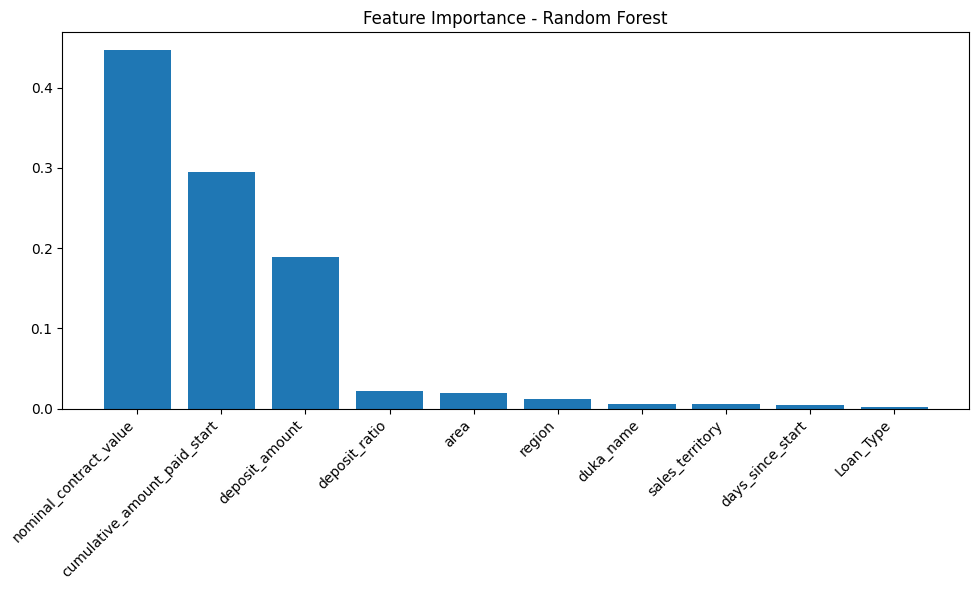


⚠️ Potential overfitting detected for XGBoost:
Train-Validation RMSE gap: 492.57
RMSE ratio (Val/Train): 1.78

Retraining with adjusted parameters...


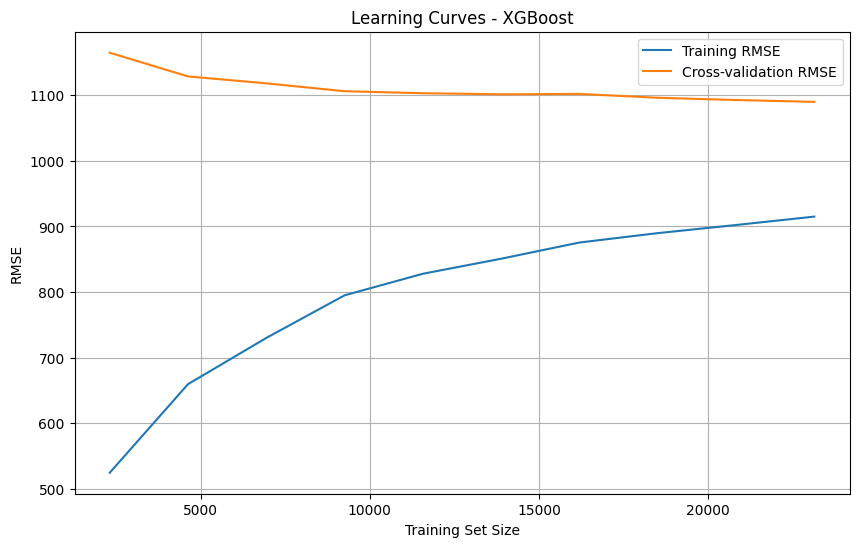

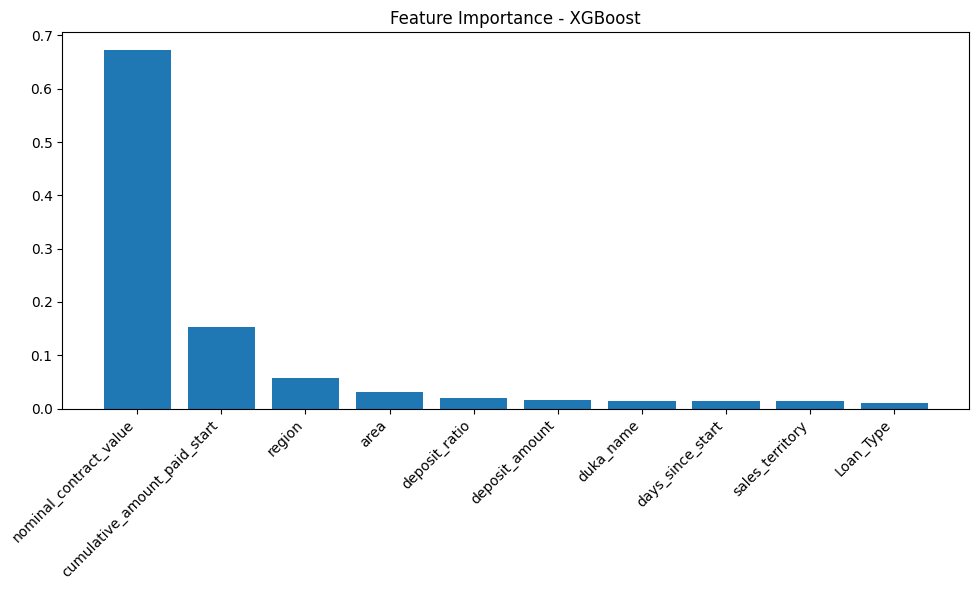

In [41]:
# Train and evaluate models
def train_and_evaluate_model(model, params, X_train, X_val, y_train, y_val, model_name):
    # Initial training and evaluation
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Make predictions
    train_pred = best_model.predict(X_train)
    val_pred = best_model.predict(X_val)

    # Calculate metrics
    results = {
        'model_name': model_name,
        'best_params': grid_search.best_params_,
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'val_rmse': np.sqrt(mean_squared_error(y_val, val_pred)),
        'train_r2': r2_score(y_train, train_pred),
        'val_r2': r2_score(y_val, val_pred)
    }

    # Check for overfitting
    rmse_diff = results['val_rmse'] - results['train_rmse']
    rmse_ratio = results['val_rmse'] / results['train_rmse']

    if rmse_ratio > 1.3:  # Overfitting threshold
        print(f"\n⚠️ Potential overfitting detected for {model_name}:")
        print(f"Train-Validation RMSE gap: {rmse_diff:.2f}")
        print(f"RMSE ratio (Val/Train): {rmse_ratio:.2f}")

        # Adjust parameters for overfitting
        if isinstance(model, RandomForestRegressor):
            new_params = {
                'n_estimators': [100, 200],
                'max_depth': [5, 8, 10],
                'min_samples_split': [5, 10],
                'min_samples_leaf': [2, 4],
                'max_features': ['sqrt', 'log2']
            }
        else:  # XGBoost
            new_params = {
                'n_estimators': [100, 200],
                'max_depth': [3, 4, 5],
                'learning_rate': [0.01, 0.05],
                'subsample': [0.8, 0.9],
                'colsample_bytree': [0.8, 0.9]
            }

        print("\nRetraining with adjusted parameters...")
        grid_search = GridSearchCV(model, new_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        train_pred = best_model.predict(X_train)
        val_pred = best_model.predict(X_val)

        # Update results
        results.update({
            'best_params': grid_search.best_params_,
            'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
            'val_rmse': np.sqrt(mean_squared_error(y_val, val_pred)),
            'train_r2': r2_score(y_train, train_pred),
            'val_r2': r2_score(y_val, val_pred)
        })

    elif rmse_ratio < 1.1 and results['val_r2'] < 0.7:  # Underfitting threshold
        print(f"\n⚠️ Potential underfitting detected for {model_name}:")
        print(f"Low R² score: {results['val_r2']:.4f}")

        # Adjust parameters for underfitting
        if isinstance(model, RandomForestRegressor):
            new_params = {
                'n_estimators': [200, 300],
                'max_depth': [15, 20, None],
                'min_samples_split': [2],
                'min_samples_leaf': [1]
            }
        else:  # XGBoost
            new_params = {
                'n_estimators': [200, 300],
                'max_depth': [6, 8],
                'learning_rate': [0.1, 0.2],
                'min_child_weight': [1, 3]
            }

        print("\nRetraining with adjusted parameters...")
        grid_search = GridSearchCV(model, new_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        train_pred = best_model.predict(X_train)
        val_pred = best_model.predict(X_val)

        # Update results
        results.update({
            'best_params': grid_search.best_params_,
            'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
            'val_rmse': np.sqrt(mean_squared_error(y_val, val_pred)),
            'train_r2': r2_score(y_train, train_pred),
            'val_r2': r2_score(y_val, val_pred)
        })

    # Plot learning curves and feature importance
    plot_learning_curves(best_model, X_train, y_train, model_name)
    analyze_feature_importance(best_model, list(X_train.columns), model_name)

    return best_model, results


rf_model, rf_results = train_and_evaluate_model(
    RandomForestRegressor(random_state=42),
    rf_params,
    X_train, X_val, y_train, y_val,
    'Random Forest'
)

xgb_model, xgb_results = train_and_evaluate_model(
    XGBRegressor(random_state=42),
    xgb_params,
    X_train, X_val, y_train, y_val,
    'XGBoost'
)


In [45]:
#print_model_results function
def print_model_results(results):
    print(f"\n=== {results['model_name']} Results ===")
    print(f"Best Parameters: {results['best_params']}")
    print(f"Train RMSE: {results['train_rmse']:.2f}")
    print(f"Validation RMSE: {results['val_rmse']:.2f}")
    print(f"Train R2: {results['train_r2']:.4f}")
    print(f"Validation R2: {results['val_r2']:.4f}")
    print(f"Validation/Train RMSE Ratio: {(results['val_rmse'] / results['train_rmse']):.3f}")

print_model_results(rf_results)
print_model_results(xgb_results)



=== Random Forest Results ===
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Train RMSE: 950.81
Validation RMSE: 1142.28
Train R2: 0.9037
Validation R2: 0.8679
Validation/Train RMSE Ratio: 1.201

=== XGBoost Results ===
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Train RMSE: 938.70
Validation RMSE: 1119.97
Train R2: 0.9062
Validation R2: 0.8730
Validation/Train RMSE Ratio: 1.193


In [46]:
# Select best model based on validation RMSE
best_model = rf_model if rf_results['val_r2'] > xgb_results['val_r2'] else xgb_model
best_model_name = 'Random Forest' if rf_results['val_r2'] > xgb_results['val_r2'] else 'XGBoost'

print(f"\n=== Best Model: {best_model_name} ===")


=== Best Model: XGBoost ===


**Feature Results**

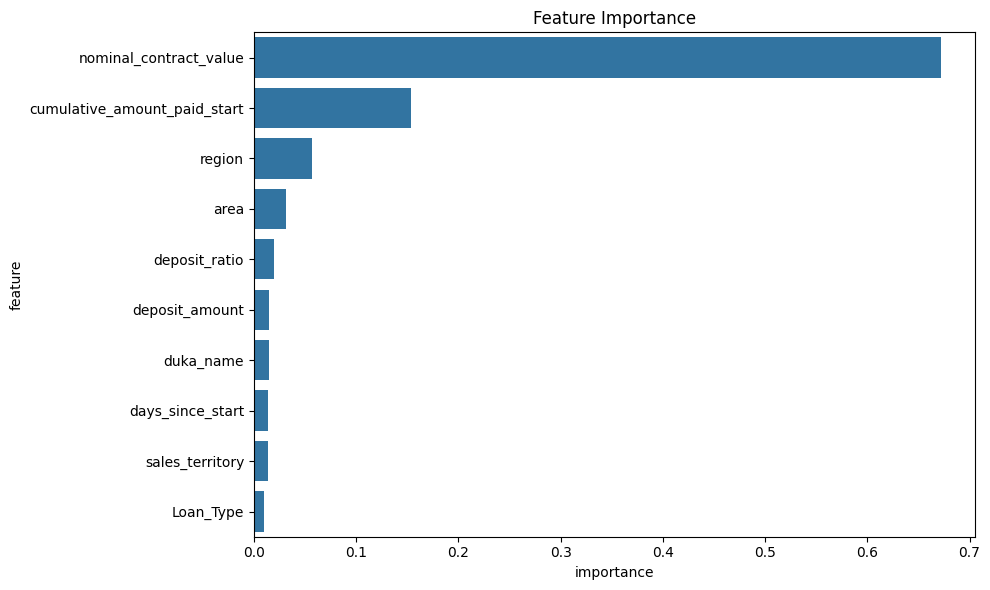


Top 10 Most Important Features:
                        feature  importance
0        nominal_contract_value    0.672222
1  cumulative_amount_paid_start    0.153424
4                        region    0.056380
6                          area    0.031453
5                 deposit_ratio    0.019399
2                deposit_amount    0.015232
9                     duka_name    0.014797
7              days_since_start    0.013551
8               sales_territory    0.013531
3                     Loan_Type    0.010011


In [47]:
# Feature importance plot
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    feat_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    })
    feat_importance = feat_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feat_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return feat_importance

feature_importance = plot_feature_importance(best_model, X.columns)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

**Holdout Prediction**

In [48]:
# Generate predictions for holdout set
holdout_predictions = best_model.predict(X_holdout)

# Create file
submission_df = pd.DataFrame({
    'client_id': holdout_ids,
    'predicted_cumulative_amount_paid': holdout_predictions
})

submission_df.to_csv('predictions.csv', index=False)
print("\nPredictions saved to 'predictions.csv'")


Predictions saved to 'predictions.csv'
